# Importing libraries

In [134]:
!pip install xgboost

In [135]:
import pandas as pd
import numpy as np, seaborn as sns, plotly.express as px, xgboost as XGB, matplotlib.pyplot as plt,plotly.graph_objects as go, math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import norm, skew

In [136]:
# Plot Customization
plt.figure(figsize = (15,9))
plt.style.context('bmh')

<Figure size 1080x648 with 0 Axes>

In [137]:
# Loading dataset
df = pd.read_csv('data.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# preprocessing

In [138]:
print(f'The dataset has {df.shape[0]} rows for each employee and {df.shape[1]} attributes\n')
print('='*80)
print('The attributes and their unique values are as above\n')
for i in df.columns:
    print(f'======== {i} ========\n')
    print(df[i].value_counts().sort_values(ascending=False))
    print('- - ' * 20)

The dataset has 1470 rows for each employee and 35 attributes

The attributes and their unique values are as above

======== Age ========

35    78
34    77
36    69
31    69
29    68
32    61
30    60
33    58
38    58
40    57
37    50
27    48
28    48
42    46
39    42
45    41
41    40
26    39
44    33
46    33
43    32
50    30
25    26
24    26
49    24
47    24
55    22
51    19
53    19
48    19
54    18
52    18
22    16
56    14
23    14
58    14
21    13
20    11
59    10
19     9
18     8
60     5
57     4
Name: Age, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
======== Attrition ========

No     1233
Yes     237
Name: Attrition, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
======== BusinessTravel ========

Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [139]:
# Dropping columns with little to no information
df = df.drop(['EmployeeCount',
                 'EmployeeNumber',
                 'Over18',
                  'StandardHours'],axis = 1)
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [142]:
df.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                   object
EducationField              object
EnvironmentSatisfaction     object
Gender                      object
HourlyRate                   int64
JobInvolvement              object
JobLevel                     int64
JobRole                     object
JobSatisfaction             object
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
OverTime                    object
PercentSalaryHike            int64
PerformanceRating           object
RelationshipSatisfaction    object
StockOptionLevel             int64
TotalWorkingYears            int64
TrainingTimesLastYear        int64
WorkLifeBalance             object
YearsAtCompany               int64
YearsInCurrentRole  

In [143]:
# Unencoding Categorical Features
col = ['EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','RelationshipSatisfaction']

for i in df['Education']:
    df['Education'].replace({1:'Below College',2:'College',3:'Bachelor',4:'Master', 5:'Doctor'},
                       inplace = True)
    
for i in df['PerformanceRating']:
    df['PerformanceRating'].replace({1:'Low', 2:'Good',3:'Excellent',4:'Outstanding'},
                                  inplace = True)
    
for i in df['WorkLifeBalance']:
    df['WorkLifeBalance'].replace({1: 'Bad', 2:'Good', 3:'Better', 4:'Best'}, 
                                  inplace = True)

for i in df[col]:
    df[i].replace({1:'Low', 2:'Medium',3:'High', 4:'Very High'},
                   inplace = True)

In [144]:
# Checking new values for decoded attributes 
decoded = ['EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','RelationshipSatisfaction',
           'Education', 'PerformanceRating', 'WorkLifeBalance']

for i in df[decoded]:
    print(f'======== {i} ========\n')
    print(df[i].value_counts().sort_values(ascending=False))
    print('- - ' * 20)

======== EnvironmentSatisfaction ========

High         453
Very High    446
Medium       287
Low          284
Name: EnvironmentSatisfaction, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
======== JobInvolvement ========

High         868
Medium       375
Very High    144
Low           83
Name: JobInvolvement, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
======== JobSatisfaction ========

Very High    459
High         442
Low          289
Medium       280
Name: JobSatisfaction, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
======== RelationshipSatisfaction ========

High         459
Very High    432
Medium       303
Low          276
Name: RelationshipSatisfaction, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
======== Education ========

Bachelor         572
Master           398
College          

*JobLevel* doesn't have a description containing its values, so I'll leave them numeric, just as they've been originally collected.

In [145]:
# Checking for missing data
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

In [146]:
!pip install -U kaleido

  Using cached kaleido-0.2.1-py2.py3-none-win_amd64.whl (65.9 MB)


ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\gokul\\anaconda3\\Lib\\site-packages\\kaleido\\executable\\version'
Consider using the `--user` option or check the permissions.



In [147]:
!pip install --upgrade "kaleido==0.1.*"

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\gokul\\anaconda3\\Lib\\site-packages\\kaleido\\executable\\version'
Consider using the `--user` option or check the permissions.



  Using cached kaleido-0.1.0.post1-py2.py3-none-win_amd64.whl (56.0 MB)


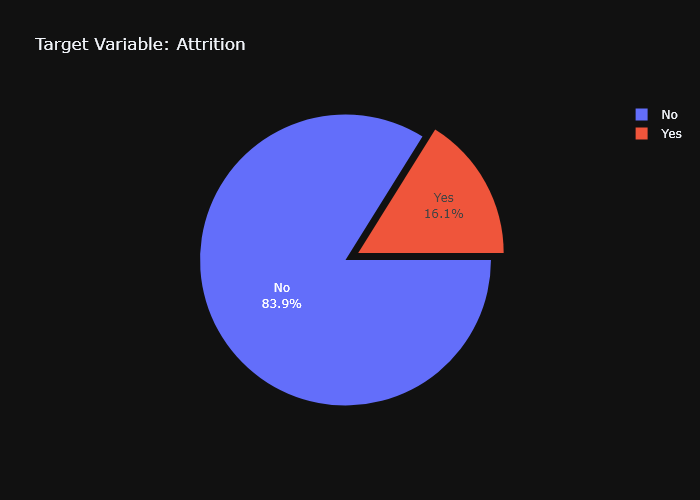

In [148]:
# Visualizing target variable classes and its distribution among the dataset
fig = px.pie(df, names = 'Attrition', title = 'Target Variable: Attrition', template = 'plotly_dark')
fig.update_traces(rotation=90, pull = [0.1], textinfo = "percent+label")
fig.show('png')


# Data Visualization and EDA<br>
To help in visualizing characteristics and try to find useful patterns, I'll create a separate dataframe containing only employees who've left the organization.

In [149]:
Attrition = df.query("Attrition == 'Yes'")
Attrition

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,College,Life Sciences,Medium,Female,...,Excellent,Low,0,8,0,Bad,6,4,0,5
2,37,Yes,Travel_Rarely,1373,Research & Development,2,College,Other,Very High,Male,...,Excellent,Medium,0,7,3,Better,0,0,0,0
14,28,Yes,Travel_Rarely,103,Research & Development,24,Bachelor,Life Sciences,High,Male,...,Excellent,Medium,0,6,4,Better,4,2,0,3
21,36,Yes,Travel_Rarely,1218,Sales,9,Master,Life Sciences,High,Male,...,Outstanding,Medium,0,10,4,Better,5,3,0,3
24,34,Yes,Travel_Rarely,699,Research & Development,6,Below College,Medical,Medium,Male,...,Excellent,High,0,8,2,Better,4,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438,23,Yes,Travel_Frequently,638,Sales,9,Bachelor,Marketing,Very High,Male,...,Excellent,Low,1,1,3,Good,1,0,1,0
1442,29,Yes,Travel_Rarely,1092,Research & Development,1,Master,Medical,Low,Male,...,Excellent,Medium,3,4,3,Best,2,2,2,2
1444,56,Yes,Travel_Rarely,310,Research & Development,7,College,Technical Degree,Very High,Male,...,Excellent,Very High,1,14,4,Bad,10,9,9,8
1452,50,Yes,Travel_Frequently,878,Sales,1,Master,Life Sciences,Medium,Male,...,Excellent,Very High,2,12,3,Better,6,3,0,1


In [150]:
print(f"{Attrition.shape[0]} emplyees in the dataset left the company.\n")
print("Let's try to find some more information about them!")

237 emplyees in the dataset left the company.

Let's try to find some more information about them!


In [151]:
# Creating a function to plot histograms
def barplot(i):
    fig = px.histogram(Attrition, x = Attrition[i], template = 'plotly_dark',
                      title = f'{i} x Attrition', text_auto = 'd3-format')
    fig.show('png')

In [152]:
!python -m pip install -U kaleido

  Using cached kaleido-0.2.1-py2.py3-none-win_amd64.whl (65.9 MB)


ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\gokul\\anaconda3\\Lib\\site-packages\\kaleido\\executable\\version'
Consider using the `--user` option or check the permissions.



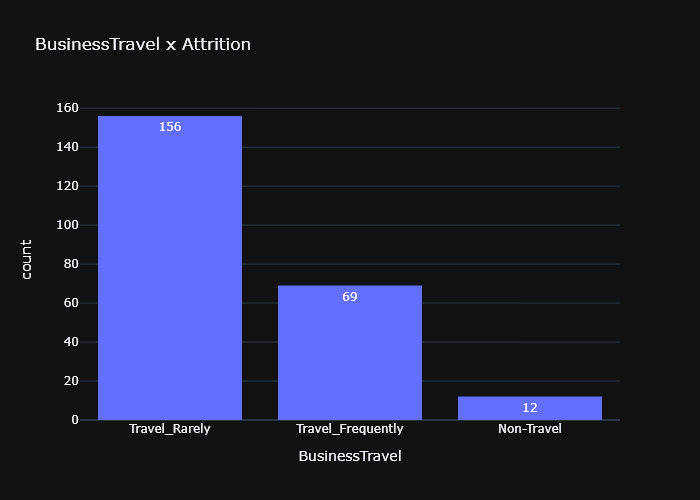

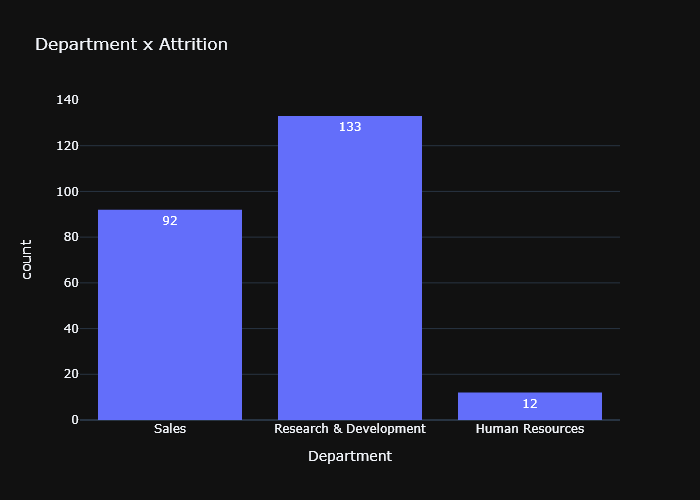

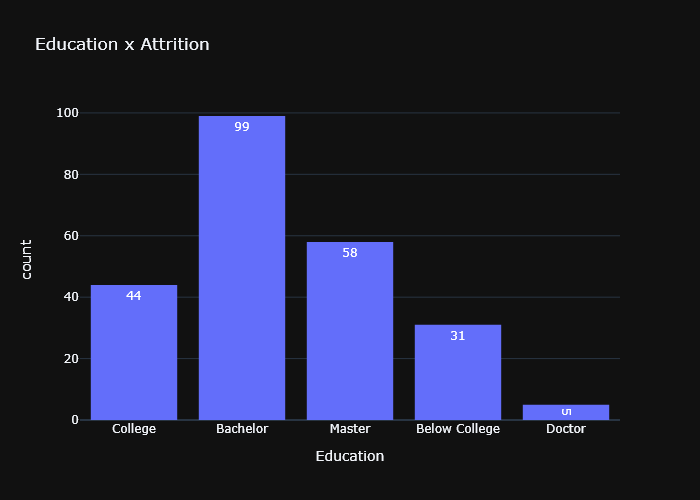

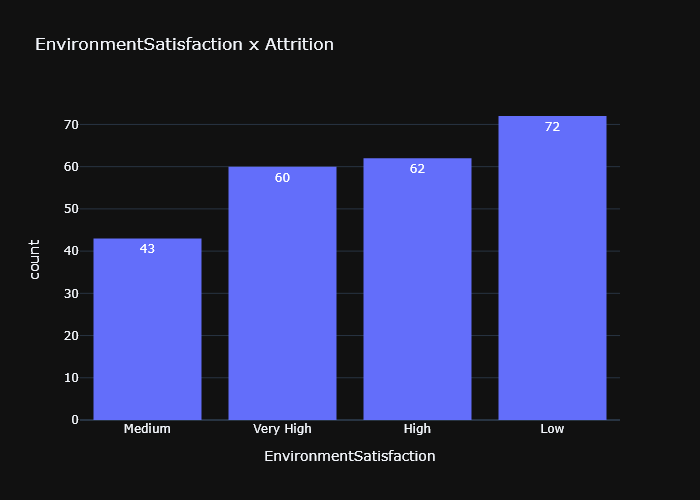

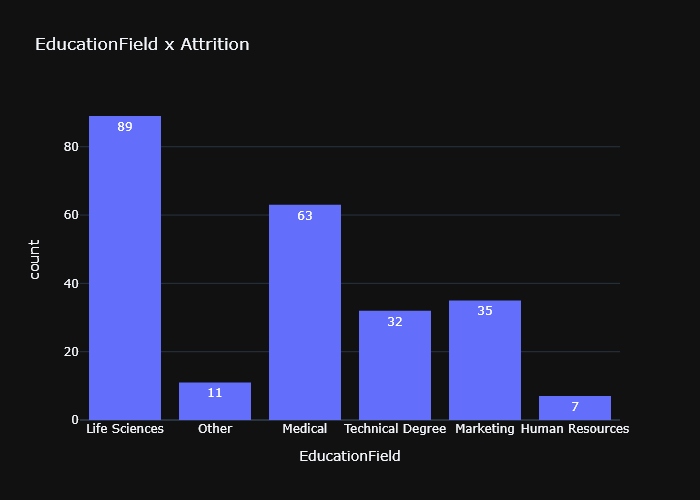

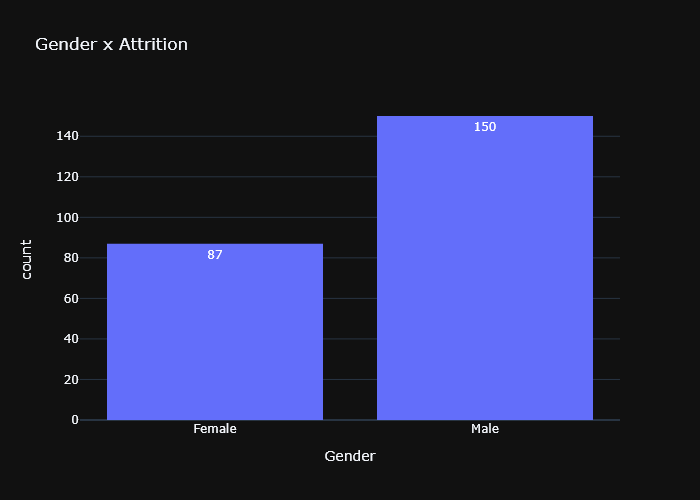

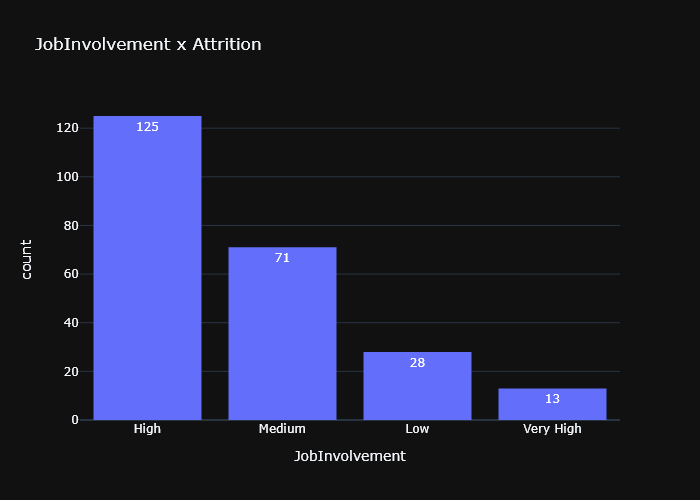

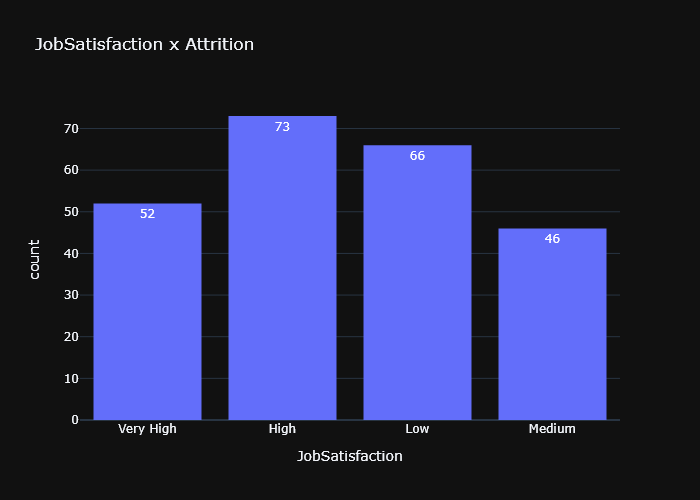

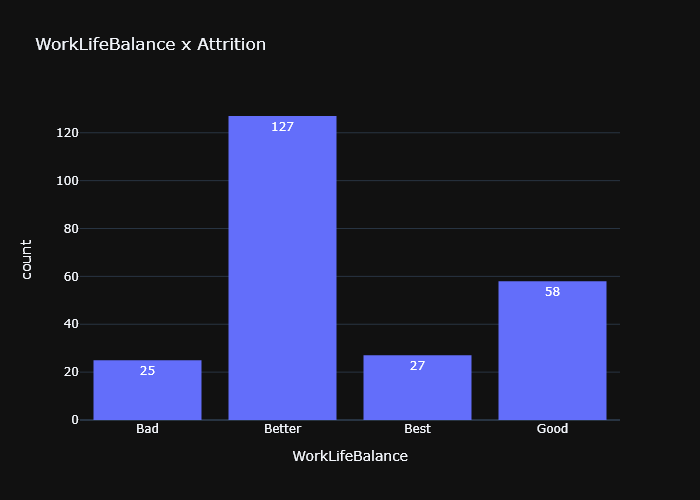

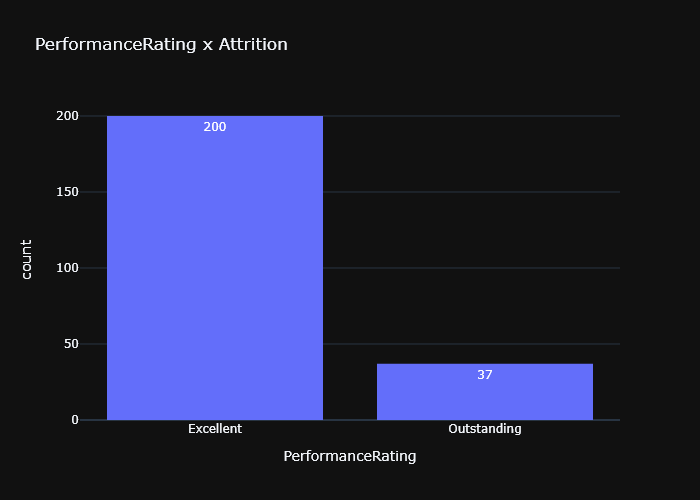

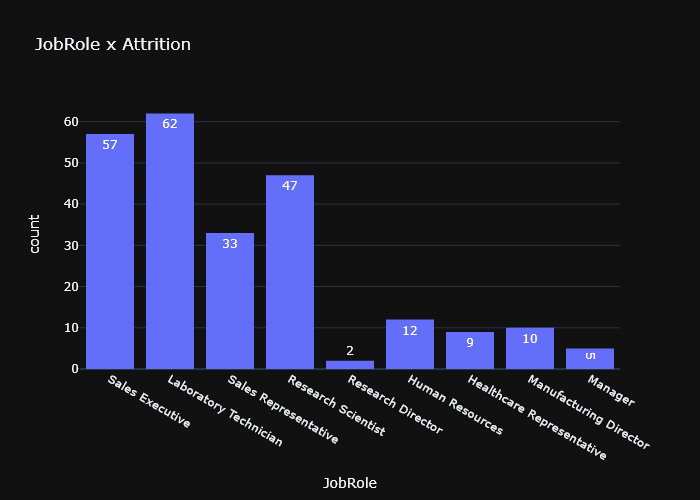

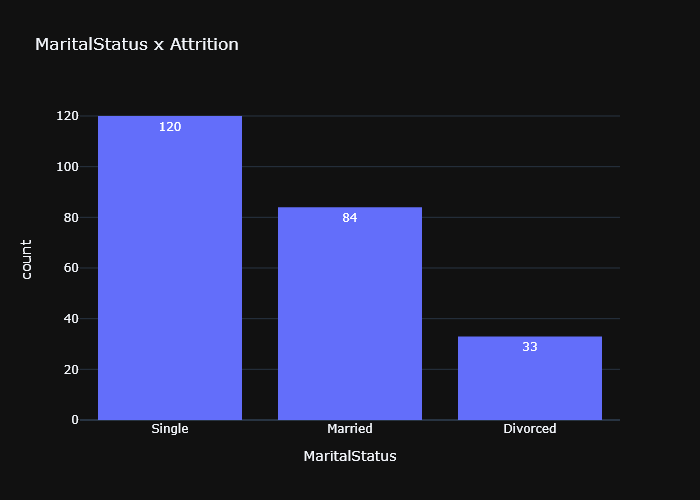

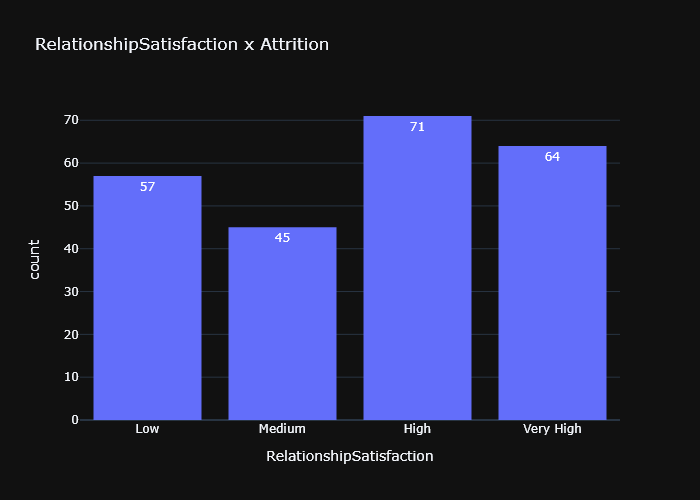

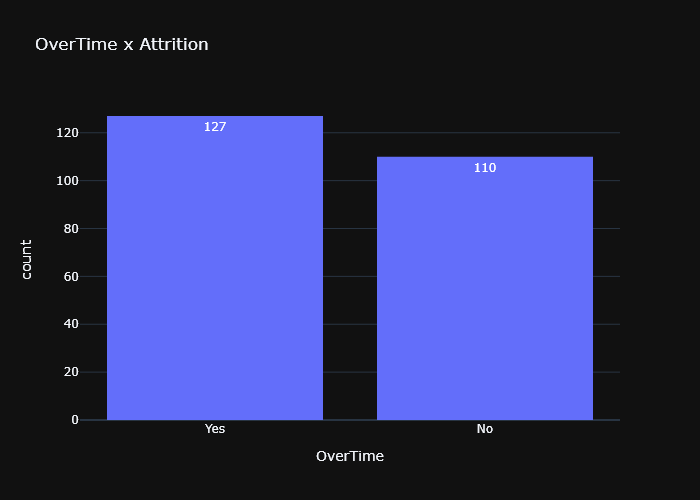

In [153]:
# Creating visualizations for categorical values
barplot('BusinessTravel')
barplot('Department')
barplot('Education')
barplot('EnvironmentSatisfaction')
barplot('EducationField')
barplot('Gender')
barplot('JobInvolvement')
barplot('JobSatisfaction')
barplot('WorkLifeBalance')
barplot('PerformanceRating')
barplot('JobRole')
barplot('MaritalStatus')
barplot('RelationshipSatisfaction')
barplot('OverTime')



In [154]:



def numeric_plot(i):
    fig = px.histogram(Attrition, x = Attrition[i], nbins  = 20, template = 'plotly_dark',
                      title = f'{i} x Attrition')
    fig.show('png')

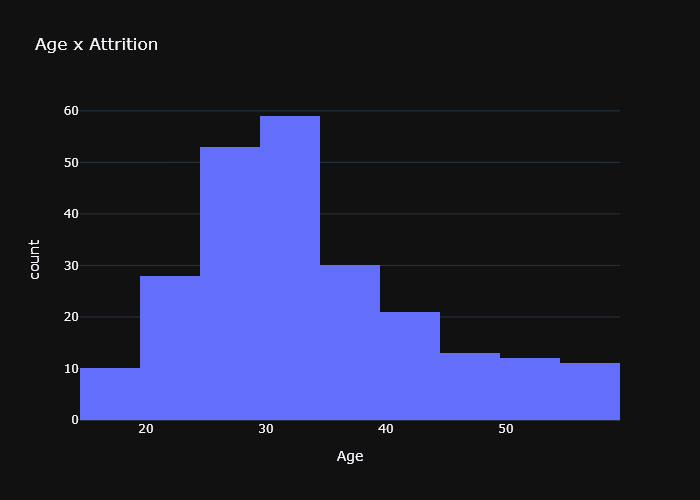

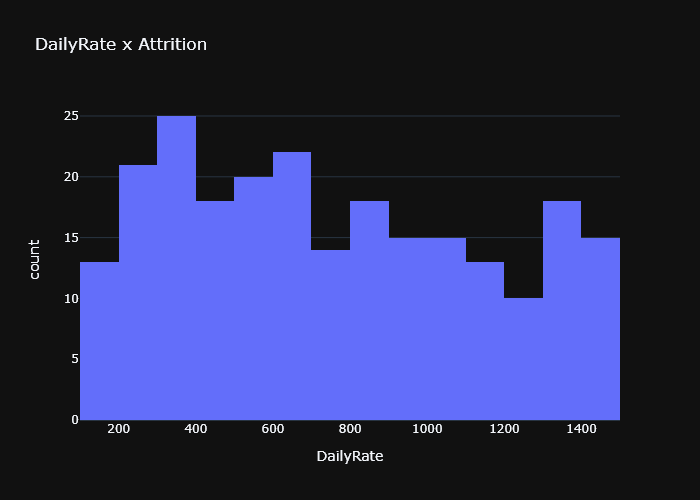

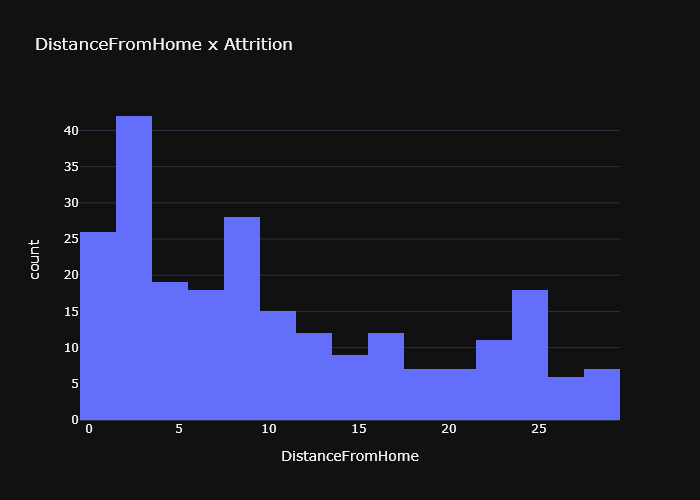

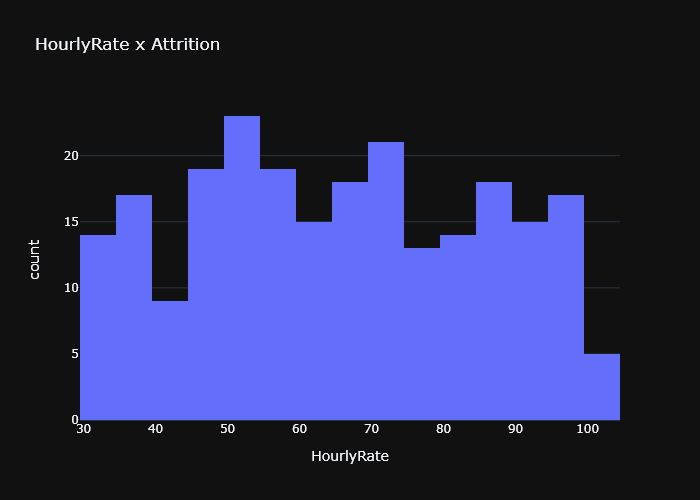

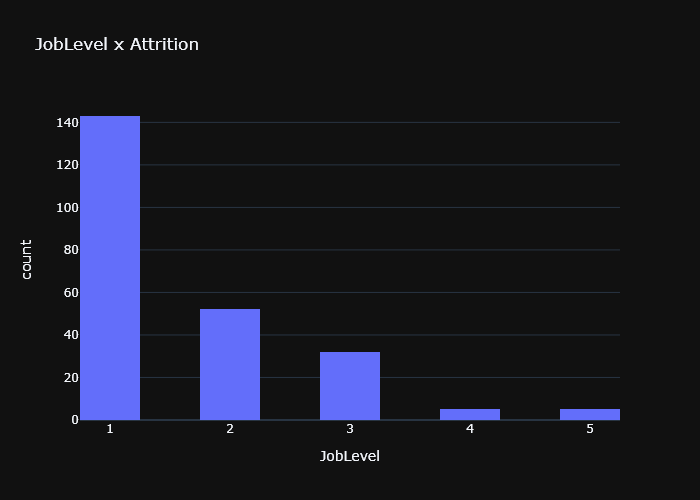

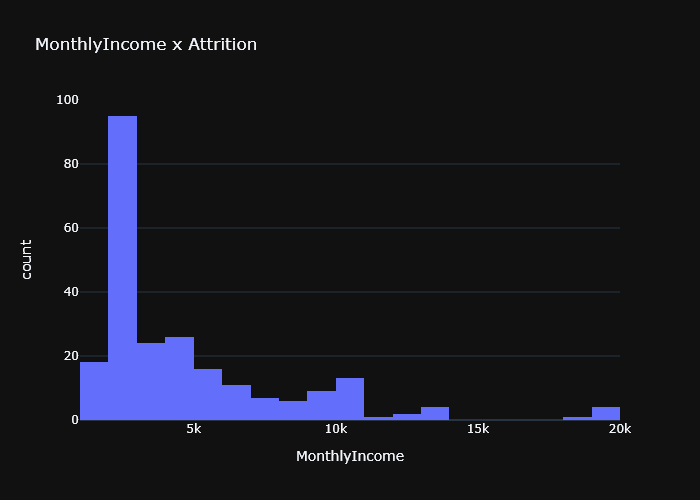

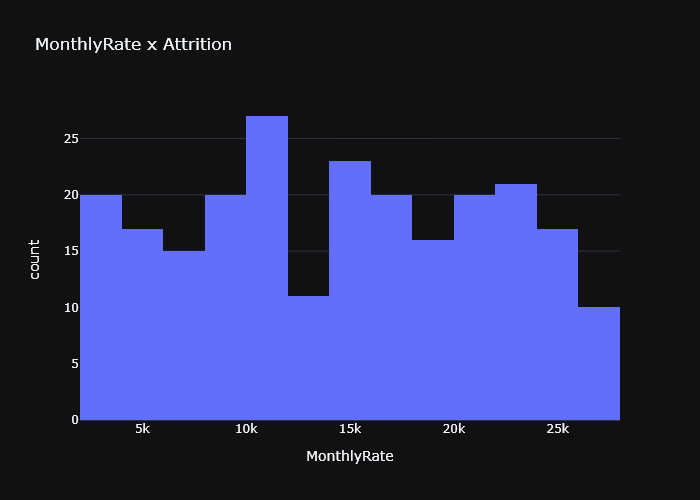

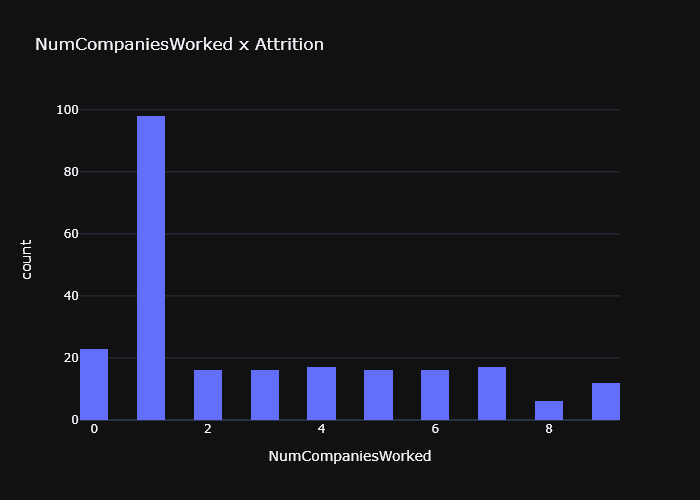

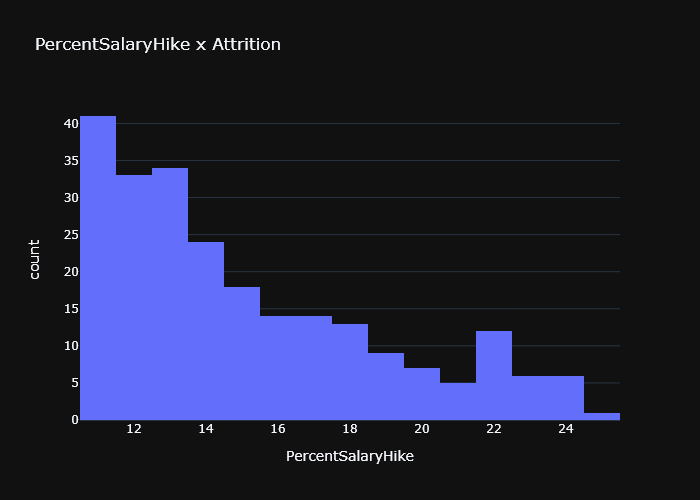

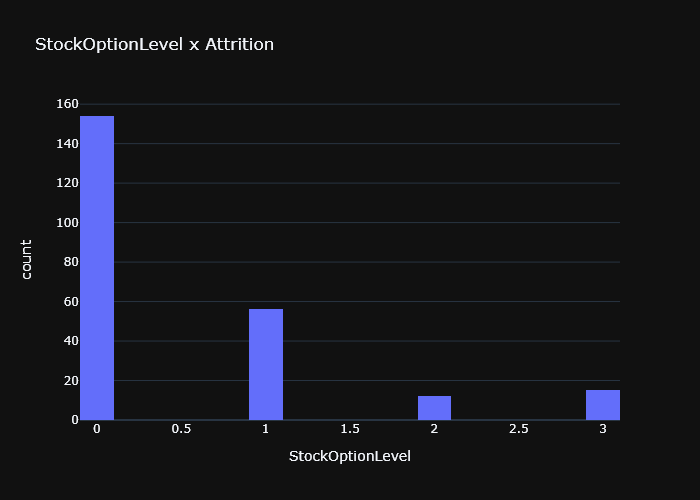

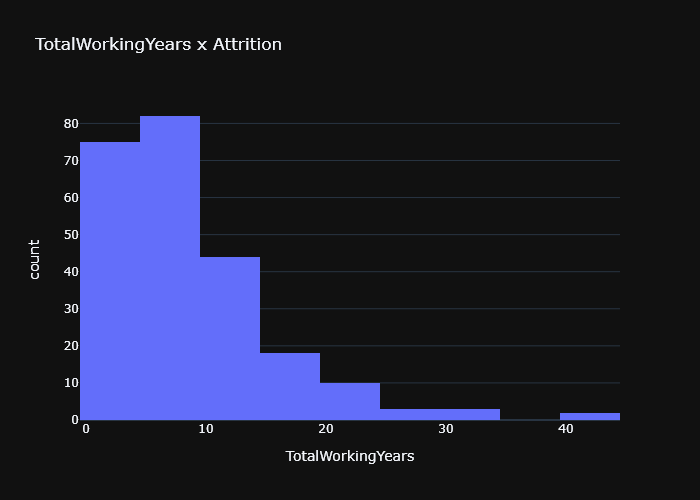

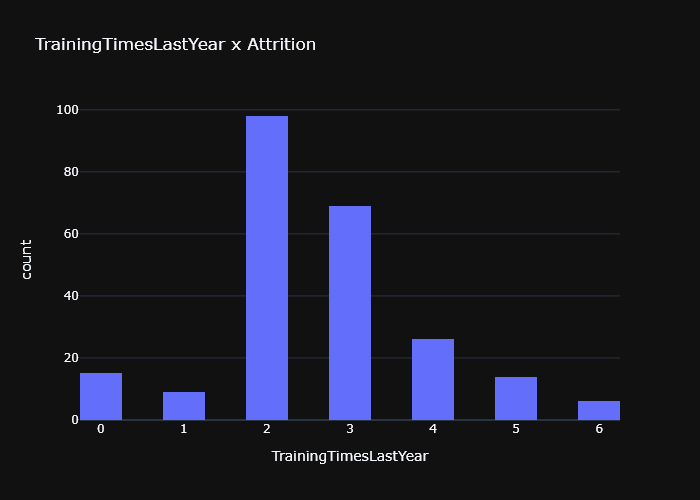

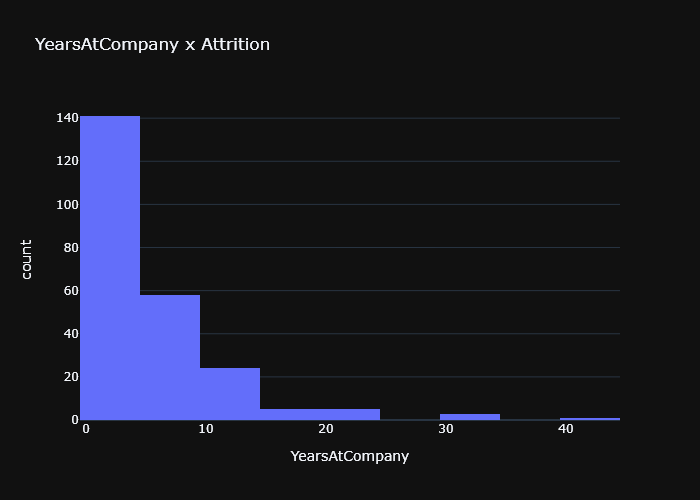

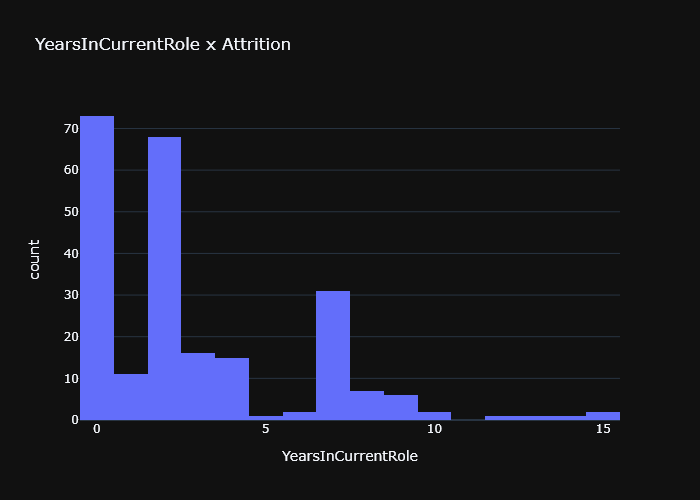

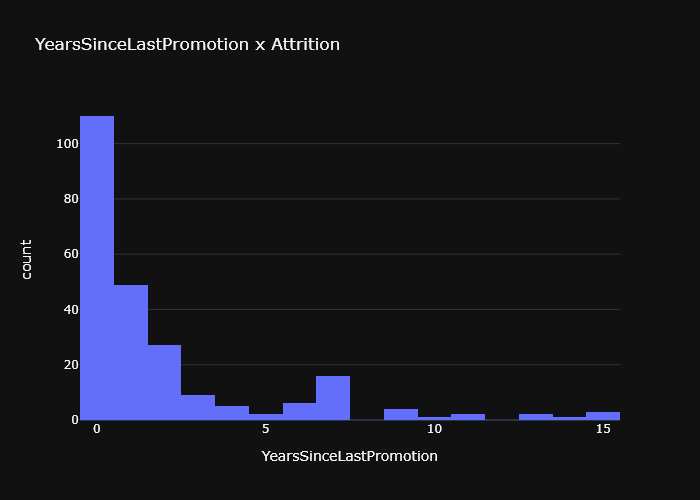

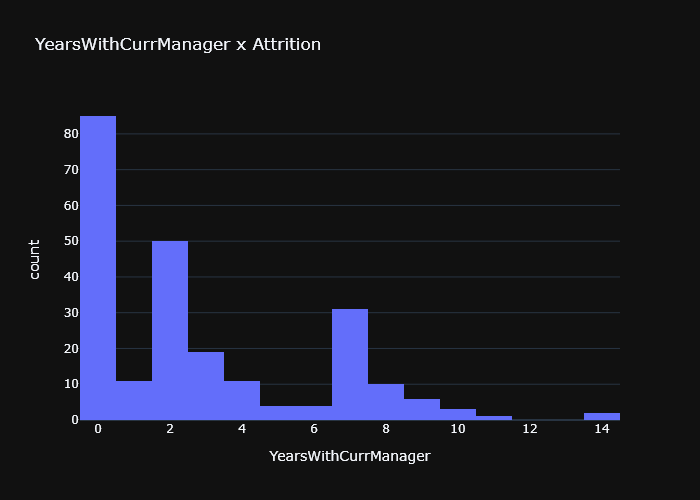

In [155]:
numeric_plot('Age')
numeric_plot('DailyRate')
numeric_plot('DistanceFromHome')
numeric_plot('HourlyRate')
numeric_plot('JobLevel')
numeric_plot('MonthlyIncome')
numeric_plot('MonthlyRate')
numeric_plot('NumCompaniesWorked')
numeric_plot('PercentSalaryHike')
numeric_plot('StockOptionLevel')
numeric_plot('TotalWorkingYears')
numeric_plot('TrainingTimesLastYear')
numeric_plot('YearsAtCompany')
numeric_plot('YearsInCurrentRole')
numeric_plot('YearsSinceLastPromotion')
numeric_plot('YearsWithCurrManager')

# Employee Attrition Prediction<br>
After looking at our data and identifying some information on employee attrition, it's time to run some classification models to try to predict when employees are more likely to leave.

In [156]:
# Splitting Dataset
X = df.drop('Attrition', axis = 1)
y = df.Attrition

In [157]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)
print('X train size: ', len(X_train))
print('X test size: ', len(X_test))
print('y train size: ', len(y_train))
print('y test size: ', len(y_test))

X train size:  1029
X test size:  441
y train size:  1029
y test size:  441


In [158]:
# Enoding categorical variables with Ordinal Encoder
OE = OrdinalEncoder()
columns_OE = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
             'JobSatisfaction','WorkLifeBalance','PerformanceRating','RelationshipSatisfaction']
X_train[columns_OE] = OE.fit_transform(X_train[columns_OE])
X_test[columns_OE] = OE.transform(X_test[columns_OE])
X_train

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1386,26,2.0,157,Research & Development,1,0.0,Medical,0.0,Male,95,...,0.0,3.0,0,8,6,3.0,7,7,7,6
790,33,2.0,654,Research & Development,5,0.0,Life Sciences,3.0,Male,34,...,0.0,0.0,1,9,2,2.0,3,2,1,2
470,24,1.0,535,Sales,24,0.0,Medical,3.0,Male,38,...,0.0,0.0,2,3,3,2.0,2,2,2,1
1065,55,2.0,1229,Research & Development,4,4.0,Life Sciences,3.0,Male,30,...,0.0,2.0,0,4,2,2.0,3,2,1,2
1181,49,2.0,465,Research & Development,6,1.0,Life Sciences,0.0,Female,41,...,0.0,2.0,1,30,3,2.0,15,11,2,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,23,2.0,977,Research & Development,10,0.0,Technical Degree,3.0,Male,45,...,0.0,3.0,1,4,2,2.0,2,2,2,2
387,40,2.0,759,Sales,2,2.0,Marketing,3.0,Female,46,...,0.0,0.0,2,8,5,2.0,5,4,1,3
1192,49,2.0,464,Research & Development,16,0.0,Medical,3.0,Female,74,...,0.0,2.0,1,17,2,3.0,2,2,2,2
245,31,1.0,1327,Research & Development,3,4.0,Medical,2.0,Male,73,...,0.0,1.0,1,9,3,2.0,2,2,2,2


In [159]:
# Transforming bicategoric variables into binary values
X_train['OverTime'].replace({'Yes': 1,
                                      'No':0}, inplace=True)
X_test['OverTime'].replace({'Yes': 1,
                                      'No':0}, inplace=True)
X_train['Gender'].replace({'Male': 1,
                                      'Female':0}, inplace=True)
X_test['Gender'].replace({'Male': 1,
                                      'Female':0}, inplace=True)

In [160]:
X_train.OverTime.value_counts()

0    744
1    285
Name: OverTime, dtype: int64

In [161]:
X_test.Gender.value_counts()

1    268
0    173
Name: Gender, dtype: int64

In [162]:
X_train

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1386,26,2.0,157,Research & Development,1,0.0,Medical,0.0,1,95,...,0.0,3.0,0,8,6,3.0,7,7,7,6
790,33,2.0,654,Research & Development,5,0.0,Life Sciences,3.0,1,34,...,0.0,0.0,1,9,2,2.0,3,2,1,2
470,24,1.0,535,Sales,24,0.0,Medical,3.0,1,38,...,0.0,0.0,2,3,3,2.0,2,2,2,1
1065,55,2.0,1229,Research & Development,4,4.0,Life Sciences,3.0,1,30,...,0.0,2.0,0,4,2,2.0,3,2,1,2
1181,49,2.0,465,Research & Development,6,1.0,Life Sciences,0.0,0,41,...,0.0,2.0,1,30,3,2.0,15,11,2,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,23,2.0,977,Research & Development,10,0.0,Technical Degree,3.0,1,45,...,0.0,3.0,1,4,2,2.0,2,2,2,2
387,40,2.0,759,Sales,2,2.0,Marketing,3.0,0,46,...,0.0,0.0,2,8,5,2.0,5,4,1,3
1192,49,2.0,464,Research & Development,16,0.0,Medical,3.0,0,74,...,0.0,2.0,1,17,2,3.0,2,2,2,2
245,31,1.0,1327,Research & Development,3,4.0,Medical,2.0,1,73,...,0.0,1.0,1,9,3,2.0,2,2,2,2


In [163]:
# Transforming bicategoric variables into binary values
X_train['OverTime'].replace({'Yes': 1,
                                      'No':0}, inplace=True)
X_test['OverTime'].replace({'Yes': 1,
                                      'No':0}, inplace=True)
X_train['Gender'].replace({'Male': 1,
                                      'Female':0}, inplace=True)
X_test['Gender'].replace({'Male': 1,
                                      'Female':0}, inplace=True)

In [164]:
X_train

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,11,12,13,14,15,16,17,18,19,20
1386,26,2.0,157,1,0.0,0.0,1,95,0.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
790,33,2.0,654,5,0.0,3.0,1,34,2.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
470,24,1.0,535,24,0.0,3.0,1,38,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1065,55,2.0,1229,4,4.0,3.0,1,30,0.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1181,49,2.0,465,6,1.0,0.0,0,41,2.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,23,2.0,977,10,0.0,3.0,1,45,3.0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
387,40,2.0,759,2,2.0,3.0,0,46,0.0,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1192,49,2.0,464,16,0.0,3.0,0,74,0.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
245,31,1.0,1327,3,4.0,2.0,1,73,0.0,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [165]:
# Rescaling Data
Scaler = MinMaxScaler()
Scaling_Cols = ['TrainingTimesLastYear','YearsAtCompany','TotalWorkingYears',
               'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager',
               'PercentSalaryHike','Age','DailyRate','DistanceFromHome','HourlyRate',
               'MonthlyIncome','MonthlyRate','NumCompaniesWorked']
X_train[Scaling_Cols] = Scaler.fit_transform(X_train[Scaling_Cols])
X_test[Scaling_Cols] = Scaler.transform(X_test[Scaling_Cols])
X_train

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,11,12,13,14,15,16,17,18,19,20
1386,0.190476,2.0,0.039455,0.000000,0.0,0.0,1,0.928571,0.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
790,0.357143,2.0,0.395983,0.142857,0.0,3.0,1,0.057143,2.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
470,0.142857,1.0,0.310617,0.821429,0.0,3.0,1,0.114286,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1065,0.880952,2.0,0.808465,0.107143,4.0,3.0,1,0.000000,0.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1181,0.738095,2.0,0.260402,0.178571,1.0,0.0,0,0.157143,2.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,0.119048,2.0,0.627690,0.321429,0.0,3.0,1,0.214286,3.0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
387,0.523810,2.0,0.471306,0.035714,2.0,3.0,0,0.228571,0.0,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1192,0.738095,2.0,0.259684,0.535714,0.0,3.0,0,0.628571,0.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
245,0.309524,1.0,0.878766,0.071429,4.0,2.0,1,0.614286,0.0,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [166]:
# Rescaling Data
Scaler = MinMaxScaler()
Scaling_Cols = ['TrainingTimesLastYear','YearsAtCompany','TotalWorkingYears',
               'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager',
               'PercentSalaryHike','Age','DailyRate','DistanceFromHome','HourlyRate',
               'MonthlyIncome','MonthlyRate','NumCompaniesWorked']
X_train[Scaling_Cols] = Scaler.fit_transform(X_train[Scaling_Cols])
X_test[Scaling_Cols] = Scaler.transform(X_test[Scaling_Cols])
X_train

No     863
Yes    166
Name: Attrition, dtype: int64
No     370
Yes     71
Name: Attrition, dtype: int64


In [167]:
y_train.replace({'No':0,
                'Yes':1}, inplace = True)
y_test.replace({'No':0,
                'Yes':1}, inplace = True)

In [168]:
print(y_train.value_counts())
print(y_test.value_counts())

0    863
1    166
Name: Attrition, dtype: int64
0    370
1     71
Name: Attrition, dtype: int64


In [169]:
!pip install imblearn

In [170]:
# Dealing with Class Imbalance using SMOTE
from imblearn.over_sampling import SMOTE
X_train,y_train = SMOTE().fit_resample(X_train,y_train)

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [171]:
y_train.value_counts()

0    863
1    863
Name: Attrition, dtype: int64

In [172]:
# Importing Models
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [173]:
adaboost = AdaBoostClassifier()
randomforest = RandomForestClassifier()
gradientboosting = GradientBoostingClassifier()
decisiontree = DecisionTreeClassifier()
xgboost =  XGBClassifier()

In [174]:
# Creating a function for predictions
def predict(model):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_predict) * 100 ))
    print('Precision: %.2f%%' % (precision_score(y_test, y_predict) * 100))
    print('Recall: %.2f%%' % (recall_score(y_test, y_predict) * 100))
    print('F1_Score: %.2f%%' % (f1_score(y_test, y_predict) * 100))
    confusion_matrix_model = confusion_matrix(y_test, y_predict)
    plt.figure(figsize=(12,8))
    ax = plt.subplot()
    sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')
    ax.set_title(f'Confusion Matrix - {model}')
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Accuracy: 76.87%
Precision: 32.18%
Recall: 39.44%
F1_Score: 35.44%


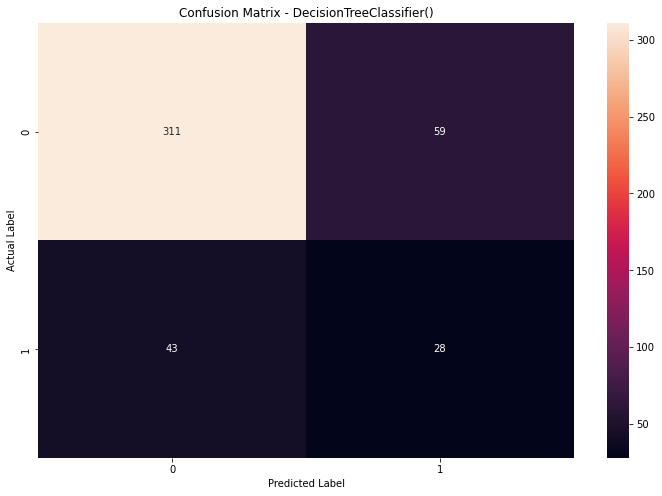

In [175]:
# Decision Tree
predict(decisiontree)

#### Ensemble Methods

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Accuracy: 84.58%
Precision: 56.52%
Recall: 18.31%
F1_Score: 27.66%


C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



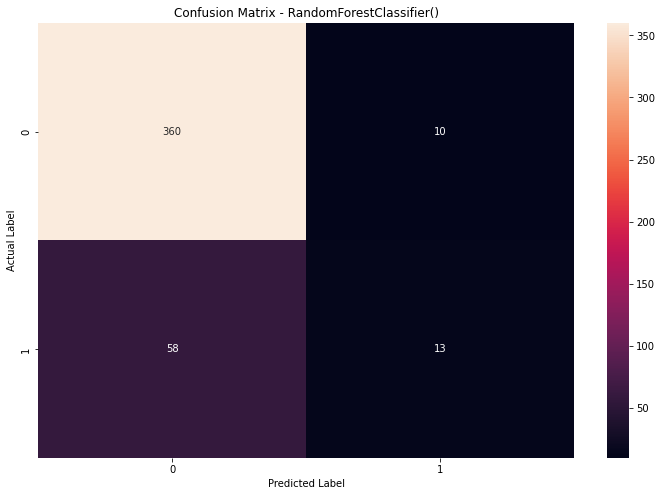

In [176]:
predict(randomforest)

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Accuracy: 84.58%
Precision: 52.38%
Recall: 46.48%
F1_Score: 49.25%


C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



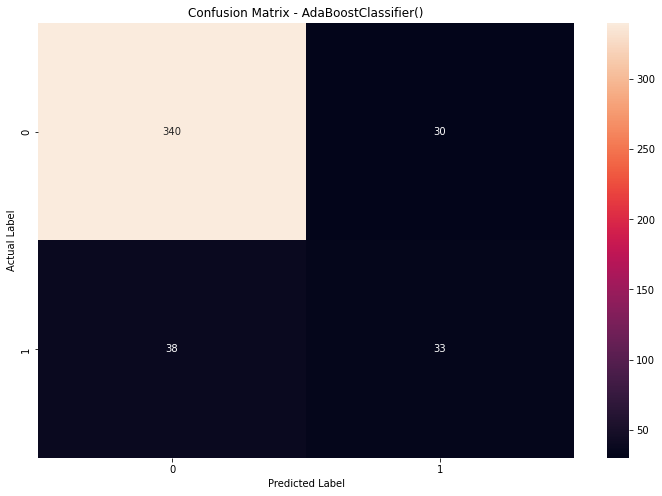

In [177]:
predict(adaboost)

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Accuracy: 86.62%
Precision: 66.67%
Recall: 33.80%
F1_Score: 44.86%


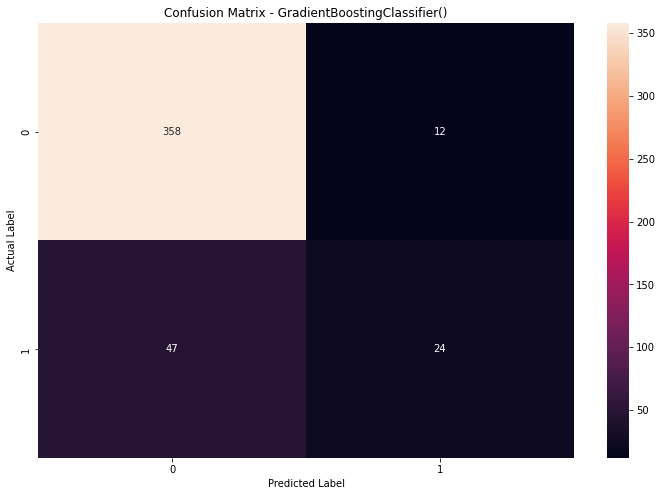

In [178]:
predict(gradientboosting)

#### XGBoost

Accuracy: 86.39%
Precision: 66.67%
Recall: 30.99%
F1_Score: 42.31%


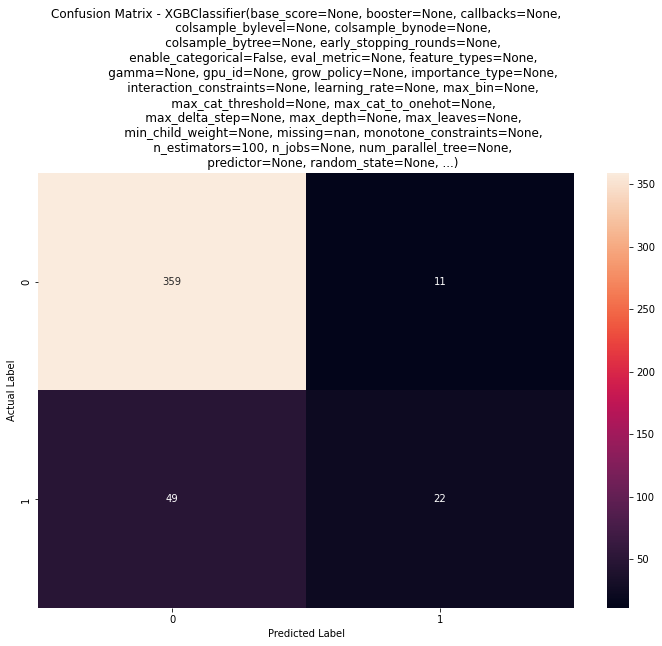

In [179]:
predict(xgboost)

## Hyperparameter

In [180]:
from sklearn.model_selection import RandomizedSearchCV

In [181]:
# Tunning Random Forest
randomforest_grid = {'n_estimators' : [100,150,200,250,300,350,400,450,500],
                    'max_depth':[5,1,15,20,25,30,40,50],
                    'criterion': ['gini','entropy'],
                    'min_samples_leaf':[2,5,8,10],
                    'min_samples_split': [2,5,8,10],
                    'max_features':['auto','sqrt']}
rf_tuning = RandomForestClassifier()
rf_search = RandomizedSearchCV(rf_tuning,param_distributions = randomforest_grid,
                              cv = 10, n_iter = 10, n_jobs = 1, verbose = 1, scoring = 'recall')
rf_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 1, 15, 20, 25, 30, 40,
                                                      50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 8, 10],
                                        'min_samples_split': [2, 5, 8, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500]},
                   scoring='recall', verbose=1)

In [182]:
rf_search.best_params_

{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'gini'}

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Accuracy: 85.71%
Precision: 65.38%
Recall: 23.94%
F1_Score: 35.05%


C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

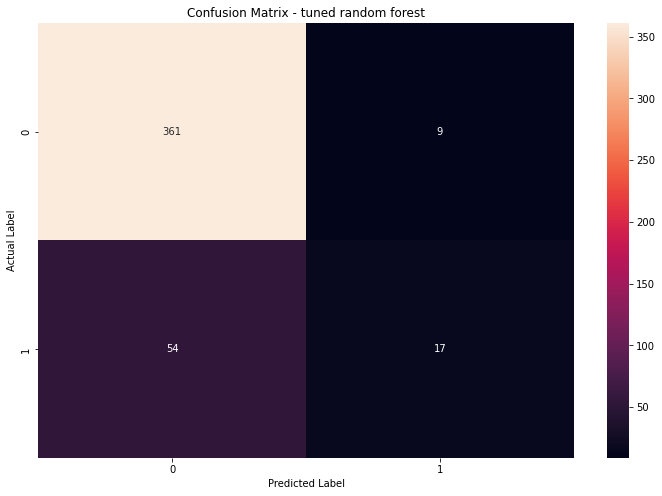

In [183]:
tuned_rf = RandomForestClassifier(**rf_search.best_params_)
tuned_rf.fit(X_train,y_train)
y_pred = tuned_rf.predict(X_test)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100 ))
print('Precision: %.2f%%' % (precision_score(y_test, y_pred) * 100))
print('Recall: %.2f%%' % (recall_score(y_test, y_pred) * 100))
print('F1_Score: %.2f%%' % (f1_score(y_test, y_pred) * 100))
confusion_matrix_model = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix - tuned random forest')
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

In [184]:
# Tuning Ada Boost
grid = {'n_estimators' : [50,100,500,1500,2000],
       'learning_rate' : [0.05,0.1,1.0,0.15,0.2,1.5,2.0],
       'algorithm': ['SAMME', 'SAMME.R']}

adaboost = RandomizedSearchCV(AdaBoostClassifier(),
                             param_distributions = grid,
                             cv = 10,
                             n_iter = 10,
                              n_jobs = 1, 
                              verbose = 1, 
                              scoring = 'recall')
adaboost.fit(X_train, y_train)

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Fitting 10 folds for each of 10 candidates, totalling 100 fits


C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

RandomizedSearchCV(cv=10, estimator=AdaBoostClassifier(), n_jobs=1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': [0.05, 0.1, 1.0, 0.15,
                                                          0.2, 1.5, 2.0],
                                        'n_estimators': [50, 100, 500, 1500,
                                                         2000]},
                   scoring='recall', verbose=1)

In [185]:
adaboost.best_params_

{'n_estimators': 1500, 'learning_rate': 0.2, 'algorithm': 'SAMME'}

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Accuracy: 85.71%
Precision: 58.00%
Recall: 40.85%
F1_Score: 47.93%


C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

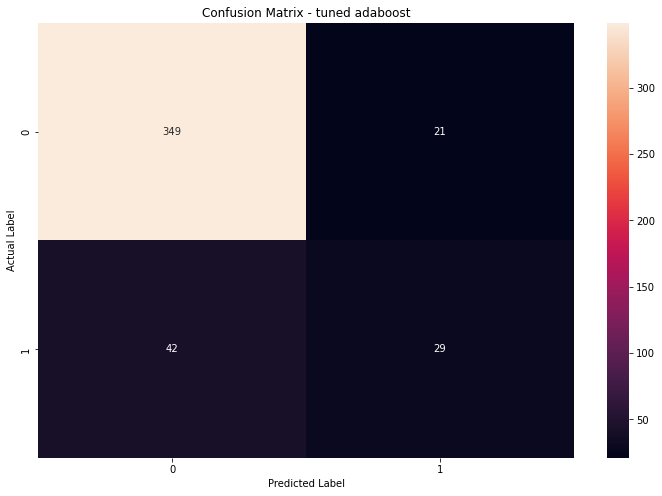

In [186]:
tuned_adaboost = AdaBoostClassifier(**adaboost.best_params_)
tuned_adaboost.fit(X_train,y_train)
y_pred = tuned_adaboost.predict(X_test)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100 ))
print('Precision: %.2f%%' % (precision_score(y_test, y_pred) * 100))
print('Recall: %.2f%%' % (recall_score(y_test, y_pred) * 100))
print('F1_Score: %.2f%%' % (f1_score(y_test, y_pred) * 100))
confusion_matrix_model = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix - tuned adaboost')
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

In [206]:
# Tuning Gradient Boosting
grid2 = {'n_estimators':[500,1000,1500,2000,2500],
        'learning_rate':[0.01,0.05,0.2,0.1,0.15,0.3,0.5],
        'min_samples_split':[2,5,6,10],
        'min_samples_leaf':[3,5,8,12],
        'criterion': ['friedman_mse', 'squared_error', 'mse'],
        'subsample': [0.1,0.2,0.5,0.6,0.8,1.0]}

gradientboosting = RandomizedSearchCV(GradientBoostingClassifier(),
                             param_distributions = grid2,
                             cv = 10,
                             n_iter = 10, n_jobs = 1, verbose=1,
                             scoring = 'recall')
gradientboosting.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarni

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error', 'mse'],
                                        'learning_rate': [0.01, 0.05, 0.2, 0.1,
                                                          0.15, 0.3, 0.5],
                                        'min_samples_leaf': [3, 5, 8, 12],
                                        'min_samples_split': [2, 5, 6, 10],
                                        'n_estimators': [500, 1000, 1500, 2000,
                                                         2500],
                                        'subsample': [0.1, 0.2, 0.5, 0.6, 0.8,
                                                      1.0]},
                   scoring='recall', verbose=1)

In [207]:
gradientboosting.best_params_

{'subsample': 0.5,
 'n_estimators': 1500,
 'min_samples_split': 2,
 'min_samples_leaf': 12,
 'learning_rate': 0.2,
 'criterion': 'squared_error'}

C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Accuracy: 86.39%
Precision: 65.71%
Recall: 32.39%
F1_Score: 43.40%


C:\Users\gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

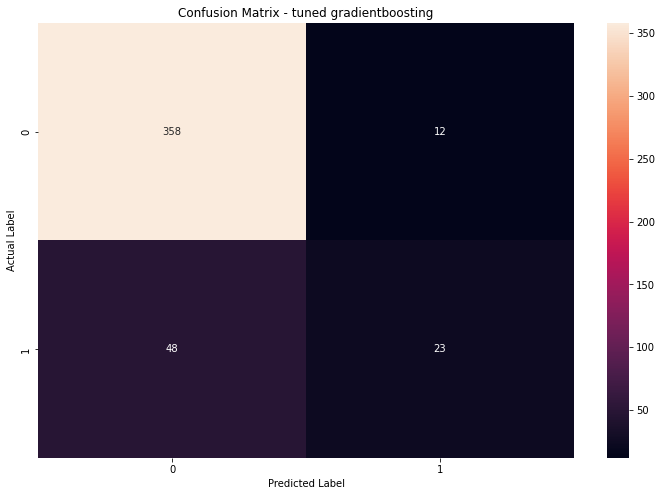

In [208]:
tuned_gradientboosting = GradientBoostingClassifier(**gradientboosting.best_params_)
tuned_gradientboosting.fit(X_train,y_train)
y_pred = tuned_gradientboosting.predict(X_test)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100 ))
print('Precision: %.2f%%' % (precision_score(y_test, y_pred) * 100))
print('Recall: %.2f%%' % (recall_score(y_test, y_pred) * 100))
print('F1_Score: %.2f%%' % (f1_score(y_test, y_pred) * 100))
confusion_matrix_model = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix - tuned gradientboosting')
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

In [209]:
# Tuning XGBoost Classifier
grid3 = {'n_estimators': [100,150,200,250,300,350,400,450,500],
              'learning_rate': [0.01, 0.5,0.2, 1.0],
              'subsample': [0.3,0.5, 0.6,0.8,1.0],
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': [0.2,0.5, 0.4,0.8,1.0],
              'min_child_weight': [1, 2, 3, 4]}
xgb = RandomizedSearchCV(XGBClassifier(),
                             param_distributions = grid3,
                             cv = 10,
                             n_iter = 10, n_jobs = 1, verbose=1,
                             scoring = 'recall')
xgb.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           n_estimators=100, n_jobs=None,
                     

In [210]:
xgb.best_params_

{'subsample': 0.5,
 'n_estimators': 400,
 'min_child_weight': 1,
 'max_depth': 8,
 'learning_rate': 1.0,
 'colsample_bytree': 0.4}

Accuracy: 82.99%
Precision: 46.00%
Recall: 32.39%
F1_Score: 38.02%


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

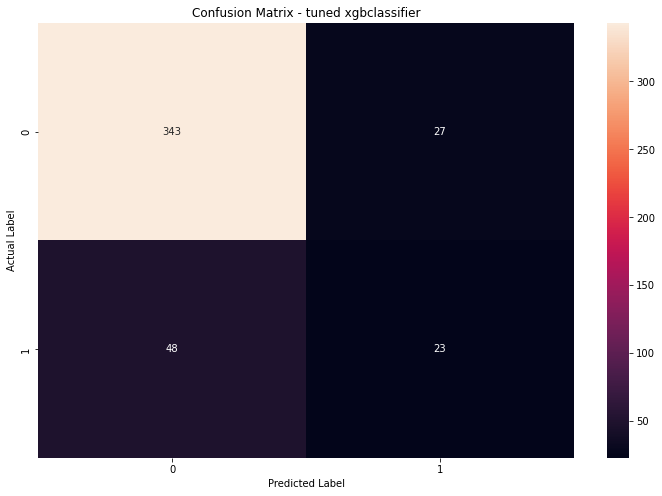

In [211]:
tuned_xgb = XGBClassifier(**xgb.best_params_)
tuned_xgb.fit(X_train,y_train)
y_pred = tuned_xgb.predict(X_test)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100 ))
print('Precision: %.2f%%' % (precision_score(y_test, y_pred) * 100))
print('Recall: %.2f%%' % (recall_score(y_test, y_pred) * 100))
print('F1_Score: %.2f%%' % (f1_score(y_test, y_pred) * 100))
confusion_matrix_model = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix - tuned xgbclassifier')
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

In [212]:
X_train.shape

(1726, 47)

# CNN

In [194]:
!pip install tensorflow

In [195]:
#importing the required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [196]:
# Creating the model
model3 = Sequential()

# input layer
model3.add(Dense(400, kernel_initializer = 'uniform', activation = 'relu', input_dim = 47))
model3.add(Dropout(0.5))

# first hidden layer
model3.add(Dense(300,kernel_initializer= 'uniform', activation = 'relu'))
model3.add(Dropout(0.5))

# second hidden layer
model3.add(Dense( 300, kernel_initializer = 'uniform', activation = 'relu'))
model3.add(Dropout(0.5))

# third hidden layer
model3.add(Dense(300,kernel_initializer = 'uniform', activation = 'relu'))
model3.add(Dropout(0.5))

# fourth hidden layer
model3.add(Dense(200, kernel_initializer = 'uniform', activation = 'relu'))
model3.add(Dropout(0.5))

# fifth hidden layer
model3.add(Dense(100,kernel_initializer = 'uniform', activation = 'relu'))
model3.add(Dropout(0.5))

# output layer
model3.add(Dense(1,kernel_initializer= 'uniform',  activation = 'sigmoid'))


In [197]:
# summarizing
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 400)               19200     
                                                                 
 dropout_12 (Dropout)        (None, 400)               0         
                                                                 
 dense_15 (Dense)            (None, 300)               120300    
                                                                 
 dropout_13 (Dropout)        (None, 300)               0         
                                                                 
 dense_16 (Dense)            (None, 300)               90300     
                                                                 
 dropout_14 (Dropout)        (None, 300)               0         
                                                                 
 dense_17 (Dense)            (None, 300)              

In [213]:
# compiling the model
hist=model3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#model.fit(xtrain,ytrain,epochs=10,Validation_data=(xtest,ytest))
hist=model3.fit(X_train,y_train, validation_data=(X_test,y_test), batch_size=50, epochs=50)

Epoch 1/50
35/35 [==============================] - 1s 15ms/step - loss: 0.2718 - accuracy: 0.8963 - val_loss: 0.5966 - val_accuracy: 0.8503
Epoch 2/50
35/35 [==============================] - 0s 10ms/step - loss: 0.2259 - accuracy: 0.9050 - val_loss: 0.6394 - val_accuracy: 0.8231
Epoch 3/50
35/35 [==============================] - 0s 9ms/step - loss: 0.2098 - accuracy: 0.9206 - val_loss: 0.6583 - val_accuracy: 0.8254
Epoch 4/50
35/35 [==============================] - 0s 9ms/step - loss: 0.2050 - accuracy: 0.9171 - val_loss: 0.7341 - val_accuracy: 0.8209
Epoch 5/50
35/35 [==============================] - 0s 10ms/step - loss: 0.1511 - accuracy: 0.9397 - val_loss: 0.8854 - val_accuracy: 0.8163
Epoch 6/50
35/35 [==============================] - 0s 9ms/step - loss: 0.1957 - accuracy: 0.9235 - val_loss: 0.6946 - val_accuracy: 0.8503
Epoch 7/50
35/35 [==============================] - 0s 10ms/step - loss: 0.1681 - accuracy: 0.9386 - val_loss: 0.9154 - val_accuracy: 0.8186
Epoch 8/50
35/35

In [215]:
res=model3.predict(X_test)

14/14 [==============================] - 0s 4ms/step


In [216]:
model3.evaluate(X_test, y_test, verbose=1)

14/14 [==============================] - 0s 5ms/step - loss: 1.5112 - accuracy: 0.8367


[1.5112491846084595, 0.8367347121238708]

In [201]:
from sklearn.metrics import r2_score
re = r2_score(y_test, res)

In [202]:
print(re)

0.02569700511399786


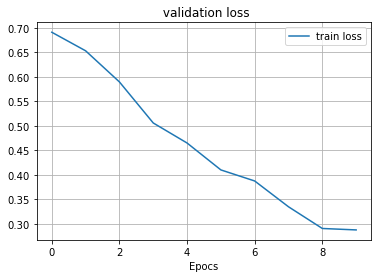

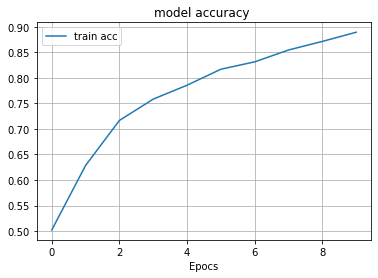

<Figure size 432x288 with 0 Axes>

In [203]:
0.02569700511399786

In [204]:
p=pd.DataFrame(X_train)
list(p.columns)
p.values
p

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,11,12,13,14,15,16,17,18,19,20
0,0.190476,2.000000,0.039455,0.000000,0.000000,0.000000,1,0.928571,0.00000,1,...,1.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,1.000000
1,0.357143,2.000000,0.395983,0.142857,0.000000,3.000000,1,0.057143,2.00000,3,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,1.0,0.000000,0.000000
2,0.142857,1.000000,0.310617,0.821429,0.000000,3.000000,1,0.114286,0.00000,1,...,0.0,0.0,0.00000,0.0,0.0,0.00000,1.000000,0.0,1.000000,0.000000
3,0.880952,2.000000,0.808465,0.107143,4.000000,3.000000,1,0.000000,0.00000,2,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,1.000000,0.000000
4,0.738095,2.000000,0.260402,0.178571,1.000000,0.000000,0,0.157143,2.00000,4,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1721,0.045068,1.000000,0.499114,0.278062,0.000000,2.946434,0,0.354335,0.00000,1,...,0.0,0.0,0.00000,0.0,0.0,0.00000,1.000000,0.0,0.000000,1.000000
1722,0.088636,1.465338,0.442587,0.353955,2.000000,2.465338,0,0.564781,0.00000,1,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.534662,0.0,0.465338,0.534662
1723,0.796362,1.223610,0.754681,0.377777,4.000000,1.000000,1,0.370099,0.77639,3,...,0.0,0.0,0.77639,0.0,0.0,0.22361,0.000000,0.0,0.000000,1.000000
1724,0.002281,1.031940,0.841500,0.145139,0.031940,2.000000,1,0.539804,0.00000,1,...,0.0,0.0,0.00000,0.0,0.0,0.00000,1.000000,0.0,0.000000,1.000000


In [3]:
df.to_csv('New_Data.csv') 

NameError: name 'df' is not defined